# Performance Attribution #

In [10]:
# Import Libraries

# Data Management
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data

In [11]:
# Now import the premiums
premiums_df = pd.read_csv(r'..\additional_data\famafrench_premiums.csv')
premiums_df.set_index('Date', inplace=True)
premiums_df.index = pd.to_datetime(premiums_df.index)
premiums_df.columns = ['mkt_premium', 'smb_premium', 'hml_premium', 'risk_free_rate']
premiums_df = premiums_df.div(100)

premiums_df

,mkt_premium,smb_premium,hml_premium,risk_free_rate
Date,,,,
2015-01-02,-0.0012,-0.0059,0.0012,0.00000
2015-01-05,-0.0184,0.0033,-0.0068,0.00000
2015-01-06,-0.0103,-0.0080,-0.0029,0.00000
2015-01-07,0.0119,0.0020,-0.0067,0.00000
2015-01-08,0.0181,-0.0012,-0.0029,0.00000
...,...,...,...,...
2025-03-25,0.0012,-0.0094,0.0005,0.00016
2025-03-26,-0.0122,-0.0048,0.0152,0.00016
2025-03-27,-0.0042,0.0019,0.0030,0.00016


In [12]:
# And we can import the betas
ff_betas = pd.read_csv(r'..\additional_data\famafrench_betas.csv')
ff_betas.rename(columns={'Unnamed: 0': 'stocks'}, inplace=True)
ff_betas.set_index('stocks', inplace=True)

ff_betas

,mkt_beta,smb_beta,hml_beta
stocks,,,
A,0.955686,0.079807,-0.134990
AAPL,1.161827,-0.290220,-0.378872
ABBV,0.616293,-0.301336,0.108055
ABT,0.786172,-0.290043,-0.130577
ADBE,1.253717,-0.235385,-0.681084
...,...,...,...
XYL,1.039345,0.146356,0.256511
YUM,0.760846,-0.183805,0.146926
ZBH,0.830569,0.124457,0.241640


### Fama and French Attribution ###

In [13]:
# Import Stock Data
ticker = 'MSFT'

# Import Data
data_stock = import_daily_financial_data(
    ticker=ticker, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,39.630863,39.973023,39.562429,39.665077,39673900,-0.009239
2015-01-06,39.049206,39.990149,38.955111,39.673650,36447900,-0.014786
2015-01-07,39.545341,39.742084,38.912344,39.331490,29114100,0.012625
2015-01-08,40.708679,40.845544,39.964479,39.990140,29645200,0.028993
2015-01-09,40.366539,40.905445,40.118474,40.725811,23944200,-0.008440
...,...,...,...,...,...,...
2024-12-24,437.647369,437.916355,432.527071,432.985301,7164500,0.009330
2024-12-26,436.432068,439.251246,434.957756,437.398354,8194200,-0.002781
2024-12-27,428.881104,433.553144,424.717120,432.935523,18117700,-0.017453


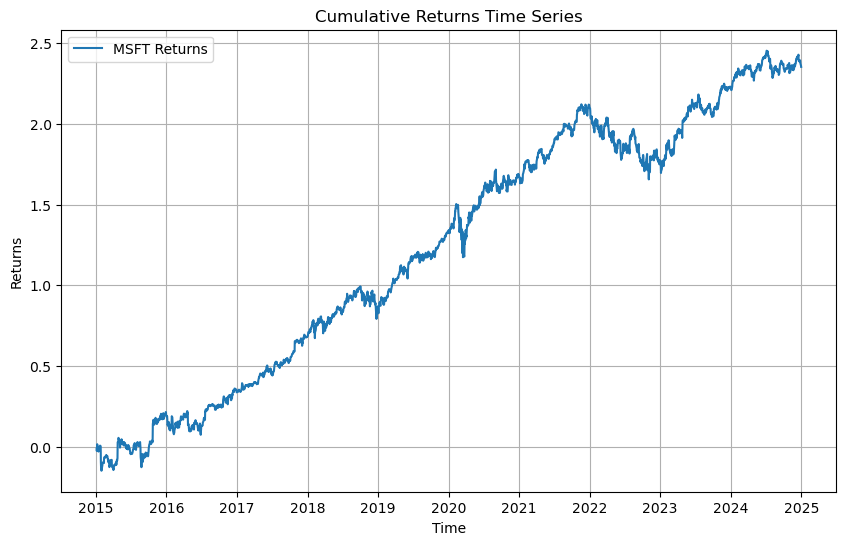

In [14]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [15]:
# Now let us calculate the returns according to the beta
mkt_contribution = ff_betas.loc[ticker]['mkt_beta'] * premiums_df['mkt_premium']
mkt_contribution.name = 'mkt_contribution'

# For Size
size_contribution = ff_betas.loc[ticker]['smb_beta'] * premiums_df['smb_premium']
size_contribution.name = 'size_contribution'

# For Value
value_contribution = ff_betas.loc[ticker]['hml_beta'] * premiums_df['hml_premium']
value_contribution.name = 'value_contribution'

In [16]:
# And to calculate the residuals we just have to take the difference
residual_returns = data_stock['returns'] - (mkt_contribution + size_contribution + value_contribution)

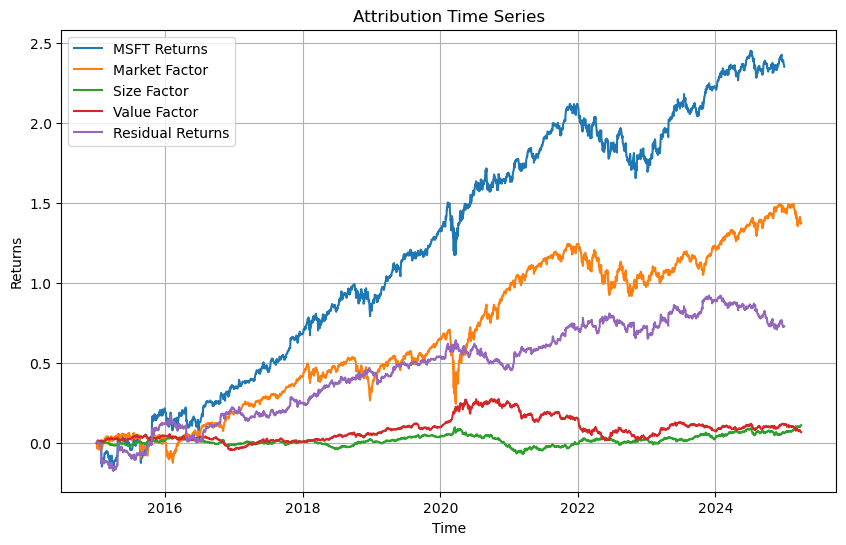

In [17]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)
plt.plot(mkt_contribution.cumsum(), label='Market Factor', alpha=1)
plt.plot(size_contribution.cumsum(), label='Size Factor', alpha=1)
plt.plot(value_contribution.cumsum(), label='Value Factor', alpha=1)
plt.plot(residual_returns.cumsum(), label='Residual Returns', alpha=1)

# Config
plt.title('Attribution Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

### Returns Contribution ###

In [37]:
# Calculate the mean contributions
mkt__mean_contribution = mkt_contribution.mean() 
size_mean_contribution = size_contribution.mean()
value_mean_contribution = value_contribution.mean()
total_mean_returns = data_stock['returns'].mean()
residual_mean_contribution = data_stock['returns'].mean() - mkt__mean_contribution - size_mean_contribution - value_mean_contribution

print(f'Market Mean Contribution: {mkt__mean_contribution * 25200}')
print(f'Size Mean Contribution: {size_mean_contribution * 25200}')
print(f'Value Mean Contribution: {value_mean_contribution * 25200}')
print(f'Residual Mean Contribution: {residual_mean_contribution * 25200}')

Market Mean Contribution: 13.440709946394303
Size Mean Contribution: 1.0978022225954696
Value Mean Contribution: 0.6669967280228386
Residual Mean Contribution: 8.352589848149236


In [39]:
# Calculate percentages
pct_res = residual_mean_contribution / total_mean_returns * 100
pct_mkt = mkt__mean_contribution / total_mean_returns * 100
pct_smb = size_mean_contribution / total_mean_returns * 100
pct_hml = value_mean_contribution / total_mean_returns * 100

print("Returns Attribution (%)")
print(f"Residuals: {pct_res:.2f}%")
print(f"Market: {pct_mkt:.2f}%")
print(f"SMB: {pct_smb:.2f}%")
print(f"HML: {pct_hml:.2f}%")

Returns Attribution (%)
Residuals: 35.46%
Market: 57.05%
SMB: 4.66%
HML: 2.83%
